In [1]:
import os
import numpy as np
from Spline import AKBSpline
from utils import draw_spline, save_tcku, dict_to_tcku, add_time_dim, draw_tra
from matplotlib import pyplot as plt 
from scipy.interpolate import splprep, splev


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


(83274, 2001, 3)
6.9068203 -6.9051213


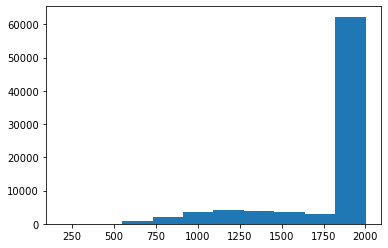

In [2]:
# tra = np.load('data/tra.npy')
# tra = tra[:,:,:3]
tra = np.load('data/tra_hcart.npy')
length = np.load('data/tra_len.npy')

print(tra.shape)
print(tra.max(),tra.min())
plt.hist(length)
plt.show()


In [3]:
k = 3
n_knots = 100
def fit_spline(trace, length):
    trace = trace[:length,:]
    
    # # t_input = [0.0] * k + np.linspace(0,1,n_knots - 2*k).tolist() + [1.0] * k
    # t_input = np.linspace(0,1,n_knots).tolist()
    # tcku, fp, ier, msg = splprep(trace.T, t=t_input, k = k, task=-1, full_output=True, quiet=True)

    spline = AKBSpline(trace, n_knots, k, para_type='uni')
    tcku = spline.tcku
    fp = spline.fp

    tck, u = tcku
    return fp/length, tck, u
err_sample, tck_sample, u_sample =fit_spline(tra[0],length[0])
print(u_sample)

[0.00000000e+00 5.00000024e-04 1.00000005e-03 ... 5.95499992e-01
 5.96000016e-01 5.96499979e-01]


In [4]:
spline = list(map(fit_spline,tra,length))


7.775309198820379e-06
100
7.391659718707497e-06
100
1.4173725553917038e-05
100


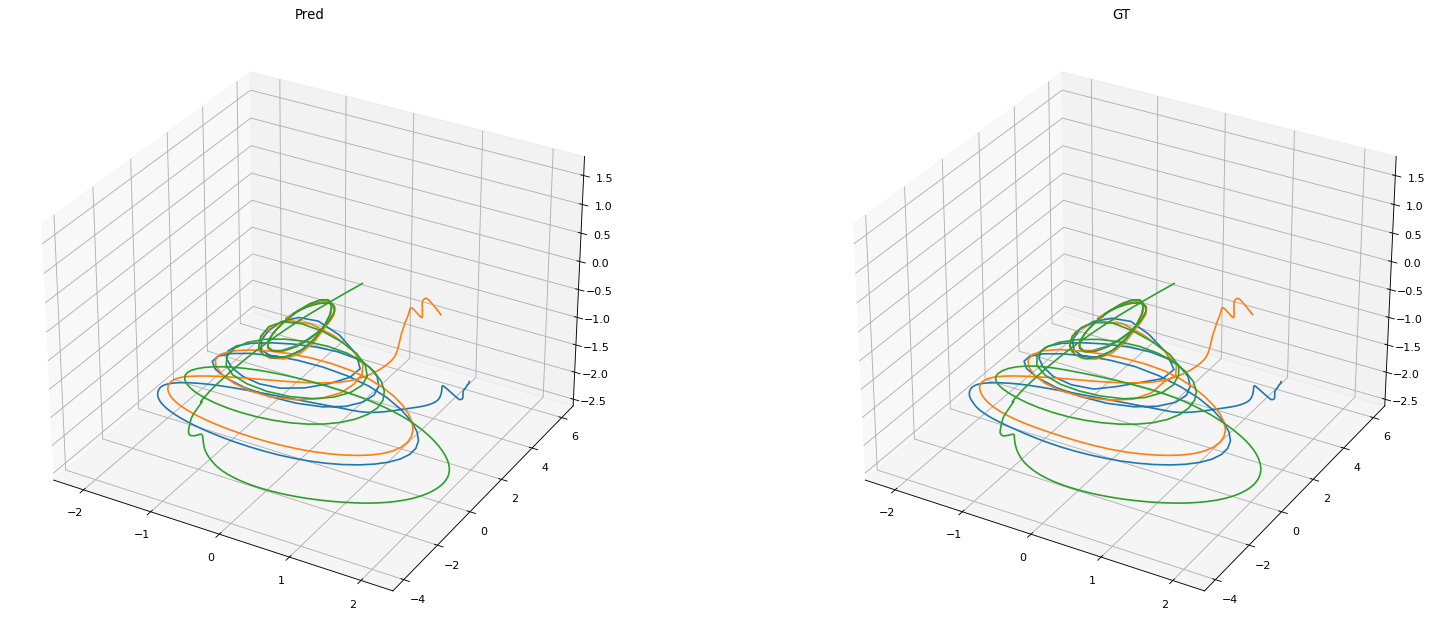

In [5]:
# draw fit results

fig = plt.figure(figsize=(24, 10), dpi=80)
ax = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax.title.set_text('Pred')
ax2.title.set_text('GT')

for i in range(10,13):
    l = 2001

    phi = np.linspace(0, 2*np.pi, l)
    x = np.sin(phi)
    y = np.cos(phi)
    rgb_cycle = np.vstack((            # Three sinusoids
        .5*(1.+np.cos(phi          )), # scaled to [0,1]
        .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
        .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

    err, tck, u = spline[i]
    print(err)
    print(len(tck[0]))
    draw_spline(tck,u,l,False,ax)

    trace = tra[i,:length[i],:]
    draw_tra(trace, l, False, ax2)
    


3.629275823398718e-05


(array([8.3266e+04, 5.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.71900948e-08, 1.17605408e-02, 2.35210344e-02, 3.52815280e-02,
        4.70420215e-02, 5.88025151e-02, 7.05630087e-02, 8.23235023e-02,
        9.40839959e-02, 1.05844489e-01, 1.17604983e-01]),
 <BarContainer object of 10 artists>)

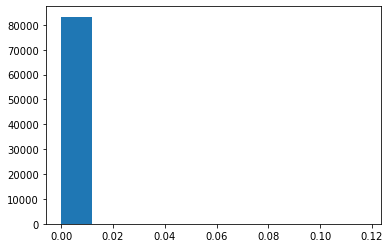

In [6]:
# error

error, tck, u = zip(*spline)
error = np.array(error)
print(np.mean(error))
plt.hist(error)

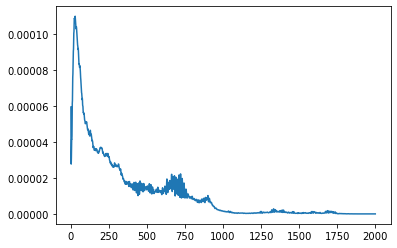

average error: 1.312406462339488e-05


In [7]:

all_e = 0
count = 0
ave_e = np.zeros((length.max()))
mask = np.zeros((length.max()),dtype=int)
for i,uu in enumerate(u):
    new_points = np.array(splev(uu, tck[i]))
    trace = tra[i,:length[i],:]
    e = ((new_points.T - trace) ** 2).mean(1)
    all_e += ((new_points.T - trace) ** 2).sum()
    count += len(trace.flatten())
    ave_e[:len(e)] += e
    mask[:len(e)] += 1
ave_e /= mask
e = all_e / count

plt.plot(np.arange(len(ave_e)),ave_e)
plt.show()
print('average error:', e)

In [8]:
save_tcku('data/spl_3d_%d.npy' % n_knots,tck,u)

In [ ]:
save_dict = np.load('data/spl_3d_%d.npy' % n_knots, allow_pickle=True).item()
tck, u = dict_to_tcku(save_dict)
save_dict_4d = np.load('data/spl_4d.npy', allow_pickle = True).item()
tck_4d, u_4d = dict_to_tcku(save_dict_4d)

In [ ]:
import pickle
pathlines_3d = []
pathlines_4d = []
for i,uu in enumerate(u):
    new_points = np.array(splev(uu, tck[i]))
    new_points_4d = np.array(splev(u_4d[i],tck_4d[i]))
    trace = tra[i,:length[i],:]
    e = ((new_points.T - trace[:,:3]) ** 2).mean(1)
    e_4d = ((new_points_4d.T - trace) ** 2).mean(1)
    new_points = np.concatenate((new_points.T,e[:,None]),axis = -1)
    new_points_4d = new_points_4d.T
    new_points_4d[:,3] = e_4d

    pathlines_4d.append(new_points_4d)
    pathlines_3d.append(new_points)


with open('data/path_3d.pkl','wb') as f:
    pickle.dump(pathlines_3d, f)
    
with open('data/path_4d.pkl','wb') as f:
    pickle.dump(pathlines_4d, f)


In [ ]:


all_e = 0
all_e_4d = 0
count = 0
count_4d = 0
ave_e = np.zeros((length.max()))
ave_e_4d = np.zeros((length.max()))
mask = np.zeros((length.max()),dtype=int)
for i,uu in enumerate(u):
    new_points = np.array(splev(uu, tck[i]))
    new_points_4d = np.array(splev(u_4d[i],tck_4d[i]))
    trace = tra[i,:length[i],:]
    e = ((new_points.T - trace[:,:3]) ** 2).mean(1)
    e_4d = ((new_points_4d.T - trace) ** 2).mean(1)
    all_e += ((new_points.T - trace[:,:3]) ** 2).sum()
    all_e_4d += ((new_points_4d.T - trace) ** 2).sum()
    count += len(trace[:,:3].flatten())
    count_4d += len(trace.flatten())
    ave_e[:len(e)] += e
    ave_e_4d[:len(e_4d)] += e_4d
    mask[:len(e)] += 1
ave_e /= mask
ave_e_4d /= mask
e = all_e / count
e_4d = all_e_4d /count_4d

print('average error:', e)
print('average error 4d:', e_4d)


In [ ]:
np.save('data/error/100_time_ave_4d', ave_e_4d)

In [ ]:
ave_e = np.load('data/error/%d_time_ave.npy' % 100)
ave_e_4d = np.load('data/error/100_time_ave_4d.npy')
ave_e = np.sqrt(ave_e)
ave_e_4d = np.sqrt(ave_e_4d)

f, ax1 = plt.subplots(1, 1, sharey=True)

ax1.plot(np.arange(len(ave_e)),ave_e, label='3D curve')
ax1.plot(np.arange(len(ave_e_4d)),ave_e_4d, label='4D curve')
plt.legend()
f.set_size_inches(9, 5)
plt.grid()
plt.show()

f.savefig('fig/3D_4D_compare.png', dpi=100)

In [ ]:
import time
for n_knots in [10,25,50,100,150]:
    print(n_knots)
    k = 3
    def fit_spline(trace, length):
        trace = trace[:length,:]
        
        # # t_input = [0.0] * k + np.linspace(0,1,n_knots - 2*k).tolist() + [1.0] * k
        # t_input = np.linspace(0,1,n_knots).tolist()
        # tcku, fp, ier, msg = splprep(trace.T, t=t_input, k = k, task=-1, full_output=True, quiet=True)

        spline = AKBSpline(trace, n_knots, k, para_type='uni')
        tcku = spline.tcku
        fp = spline.fp

        tck, u = tcku
        return fp/length, tck, u
    t1 = time.time()
    spline = list(map(fit_spline,tra[:,:,:3],length))
    print('fitting time:', time.time() - t1)
    error, tck, u = zip(*spline)
    save_tcku('data/spl_3d_cp_%d.npy' % n_knots,tck,u)

    all_e = 0
    count = 0
    ave_e = np.zeros((length.max()))
    mask = np.zeros((length.max()),dtype=int)
    for i,uu in enumerate(u):
        new_points = np.array(splev(uu, tck[i]))
        trace = tra[i,:length[i],:3]
        e = ((new_points.T - trace) ** 2).mean(1)
        all_e += ((new_points.T - trace) ** 2).sum()
        count += len(trace.flatten())
        ave_e[:len(e)] += e
        mask[:len(e)] += 1
    ave_e /= mask
    e = all_e / count

    print('average error:', e)
    np.save('data/error/%d_time_ave.npy' % n_knots, ave_e)
    

In [ ]:

f, ax = plt.subplots(1, 1, sharey=True)

for i,n in enumerate([10,25,50,100]):
    error = np.load('data/error/%d_time_ave.npy' % n)
    error = np.sqrt(error)
    ax.plot(np.arange(len(error)),error, label=n)
plt.legend()
f.set_size_inches(9, 5)
plt.grid()
plt.show()
f.savefig('fig/different_n.png', dpi=100)
    